In [5]:
import numpy as np
import pandas as pd
import os, time
import itertools
from time import time

from pandas import read_csv, Series, DataFrame
from pandas.tools.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

from matplotlib.pylab import rcParams
rcParams['font.family'] = 'Ubuntu'
rcParams['lines.linewidth'] = 2.5
rcParams['figure.figsize'] = 14, 4

/Users/dkhosla/miniconda2/envs/pmi-ds-env/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


---
## Explore the time-series for trend, seasonality, outliers

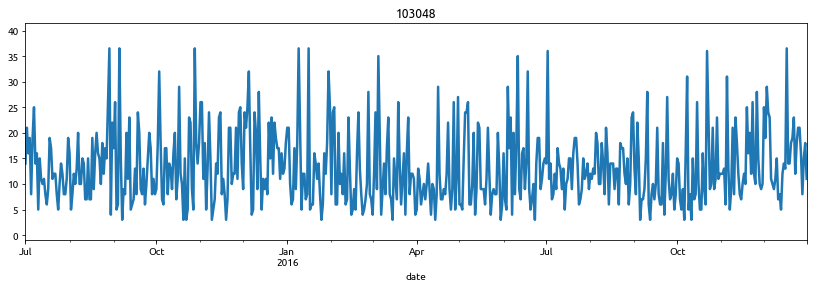

In [12]:
df_sales = pd.read_csv("ts-data-few-missings.csv", parse_dates=['date']).set_index('date').loc['2015-07':]
df_holidays = pd.read_csv("ts-holidays.csv", parse_dates=['date'])

ITEM = Series(df_sales.columns.tolist()).sample(1).iloc[0]
y = df_sales[ITEM].copy()

# clean
y.fillna(method='bfill', inplace=True)
y = y.clip_upper(y.quantile(0.99)).clip_lower(y.quantile(0.01))
y.dropna(inplace=True)

# visualize
y.plot(title=ITEM, ylim=(-1, y.max() + 5));

## Create Predictors


In [13]:
df_sales = pd.concat([y.to_frame(name='y'), 
                      df_holidays.set_index('date')], axis=1).reset_index()

df_sales.loc[:, 'date'] = pd.to_datetime(df_sales['date'])
dummies_month = pd.get_dummies(df_sales.date.dt.month, prefix='month')
dummies_weekday = pd.get_dummies(df_sales.date.dt.weekday, prefix='dayofweek')

df_sales.loc[:, 'is_weekend'] = df_sales.date.dt.weekday.map(lambda x: x > 4).astype(int)

df_sales.loc[:, 'is_holiday'] = df_sales.is_holiday.fillna(0)
df_sales.loc[:, 'days_before_holidays'] = (pd.concat([df_sales['is_holiday'].shift(-i) for i in [1, 2]], axis=1)
                                           .sum(axis=1)
                                           .fillna(0)
                                           .astype(int)
                                           .map(lambda x: 1 if x > 1 else x))

df_sales.loc[:, 'days_after_holidays'] = (pd.concat([df_sales['is_holiday'].shift(i) for i in [1, 2]], axis=1)
                                           .sum(axis=1)
                                          .fillna(0)
                                          .astype(int)
                                          .map(lambda x: 1 if x > 1 else x))


df_sales = pd.concat([df_sales, dummies_month, dummies_weekday], axis=1)

y = Series(data=df_sales['y'].values, index=pd.to_datetime(df_sales['date']))

X = df_sales.set_index('date').drop(['y'], axis=1)
X.columns

Index([u'is_holiday', u'is_weekend', u'days_before_holidays',
       u'days_after_holidays', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'dayofweek_0', u'dayofweek_1',
       u'dayofweek_2', u'dayofweek_3', u'dayofweek_4', u'dayofweek_5',
       u'dayofweek_6'],
      dtype='object')

## Functions

In [14]:
def run_sm_sarima(y=Series(), ORDER=tuple(), fh=int()):
    """
    """
    y_tr = y.iloc[:-fh]
    y_te = Series(y.iloc[-fh:].values, index=pd.date_range(start=y.index[-fh], periods=fh))

    m = SARIMAX(y_tr, order=ORDER[0], seasonal_order=ORDER[1]).fit()
    yhat, ci = m.forecast(steps=fh), m.get_prediction(end=m.nobs + fh).conf_int()

    df = \
    pd.concat([
        Series(y_te).to_frame('y'),
        Series(yhat, index=y_te.index).to_frame('yhat'),
        DataFrame(ci.loc[y_te.index, :].values, columns=['yhat_lower', 'yhat_upper'], index=y_te.index)], axis=1)

    return {'model': m,
           'order': ORDER,
           'model_aic': m.aic,
           'model_rmse': get_perf_metrics(df).get('RMSE'),
           'model_mape': get_perf_metrics(df).get('MAPE'),
           'df': df}

In [15]:
def run_sm_sarimax(y=Series(), Xs=DataFrame(), ORDER=tuple(), fh=int()):
    """
    """
    y_tr = y.iloc[:-fh]
    y_te = Series(y.iloc[-fh:].values, index=pd.date_range(start=y.index[-fh], periods=fh))

    X_tr = X.loc[y_tr.index]
    X_te = X.loc[y_te.index]
    try:
        m = SARIMAX(endog=y_tr, order=ORDER[0], seasonal_order=ORDER[1], exog=X_tr).fit()
        yhat = m.forecast(steps=fh, exog=X_te)
        ci = m.get_prediction(end=m.nobs + fh-1, exog=X_te).conf_int()

        df = \
        pd.concat([
            Series(y_te).to_frame('y'),
            Series(yhat, index=y_te.index).to_frame('yhat'),
            DataFrame(ci.loc[y_te.index, :].values, columns=['yhat_lower', 'yhat_upper'], index=y_te.index)], axis=1)
        
        return {'model': m,
               'order': ORDER,
               'model_aic': m.aic,
               'model_rmse': get_perf_metrics(df).get('RMSE'),
               'model_mape': get_perf_metrics(df).get('MAPE'),
               'df': df}
    except:
        print "Failed for order {}".format(ORDER)
        pass

In [16]:
def visualize_forecasts(y=Series(), df=DataFrame(), fh=int()):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    y.to_frame(name='y').iloc[-fh * 3:, :].plot(ax=ax)
    ax_1 = df.drop('y', axis=1).plot(ax=ax, color=('r', 'k', 'k'), alpha=0.3)
    ax_1.fill_between(df.index, df['yhat_upper'], df['yhat_lower'], color='k', alpha=.2)

def get_perf_metrics(df_predicted):
    """
    """
    y = df_predicted['y'].copy()
    yhat = df_predicted['yhat'].copy()
    
    mse = np.mean((y - yhat)**2)
    perc_err = (100*(y - yhat))/y
    
    return {'RMSE': np.sqrt(mse), 
            'MAPE': np.mean(abs(perc_err))}

## Grid Search SARIMA

In [17]:
p = [1, 2]
q = [0, 1]
d = [1]
pdq = list(itertools.product(p, d, q))
PDQ = [tuple(list(x) + [7]) for x in pdq]
grid = list(itertools.product(pdq, PDQ))


In [18]:
# def grid_search():
list_gs = []
for pdqPDQs in grid[1:]:
    """
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    result = run_sm_sarima(y=y.copy(), ORDER=pdqPDQs, fh=30)
    try:
        list_gs.append(Series({k:result.get(k) for k in ['order', 'model_rmse', 'model_mape', 'model_aic', 'df']}))
    except:
        continue

df_order_select__SARIMA = pd.concat(list_gs, axis=1).T.set_index('order').round(2)
winner = df_order_select__SARIMA['model_aic'].idxmin()
print "The winning order is {}".format(winner)
df_predicted__SARIMA = df_order_select__SARIMA.loc[[winner], 'df'].iloc[0]

The winning order is ((2, 1, 1), (1, 1, 1, 7))


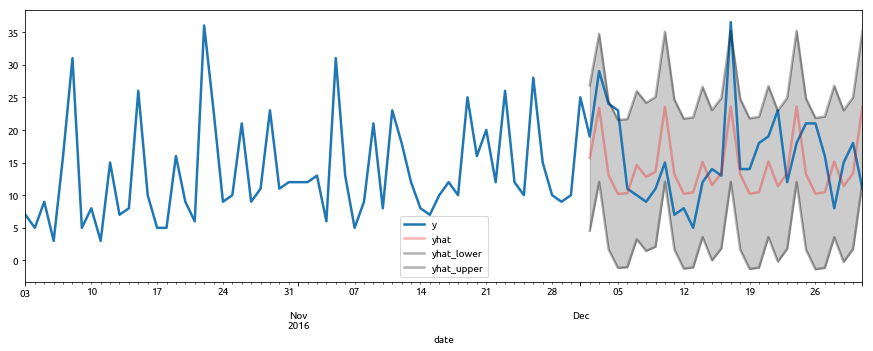

In [19]:
visualize_forecasts(y=y, df=df_predicted__SARIMA, fh=30)

## Grid Search SARIMAX

In [20]:
# def grid_search():
list_gs = []
for ORDER in grid[1:]:
    """
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    result = run_sm_sarimax(y=y.copy(), Xs=X.copy(), ORDER=ORDER, fh=30)
    try:
        list_gs.append(Series({k:result.get(k) for k in ['order', 'model_rmse', 'model_mape', 'model_aic', 'df']}))
    except:
        continue

In [21]:
df_order_select__SARIMAX = pd.concat(list_gs, axis=1).T.set_index('order').round(2)
winner = df_order_select__SARIMAX['model_aic'].idxmin()
print "The winning order is {}".format(winner)
df_predicted__SARIMAX = df_order_select__SARIMAX.loc[[winner], 'df'].iloc[0]

The winning order is ((1, 1, 1), (1, 1, 1, 7))


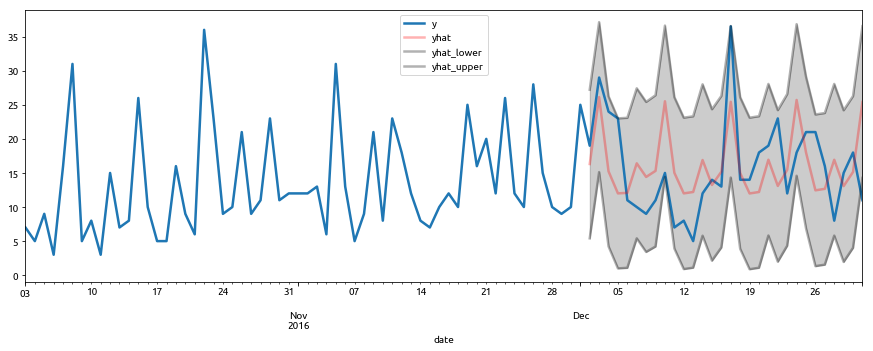

In [22]:
visualize_forecasts(y=y, df=df_predicted__SARIMAX, fh=30)